The agent and environment continuously interact with each other. At each time step, the agent takes an action on the environment based on its policy 
, where 
 is the current observation from the environment, and receives a reward 
 and the next observation 
 from the environment. The goal is to improve the policy so as to maximize the sum of rewards (return).

In [2]:
# screen capture
from mss import mss
# sending commands
import pydirectinput
# frame processing
import cv2
# transformational framework
import numpy as np
# ocr game over
import pytesseract
# visualize captured frames
import matplotlib.pyplot as plt
# pauses
import time
# environment components
from gymnasium import Env     # Env base environment
# spaces box - represent game input image/ discrete - represent possible actions (agent, reward, environment, action)
from gymnasium.spaces import Box, Discrete

pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

chrome://dino/

# Environment

## Create

In [3]:
class WebGame(Env):
    # initialization function, set-up, environment action and observation shapes
    def __init__(self): 

        # subclass model
        super().__init__()

        # setup spaces / multidimentional array as return output / 1 batch 83x100 / datatype / gives back an image
        self.observation_space = Box(low = 0, high = 255, shape = (1, 83, 100), dtype = np.uint8)
        self.action_space = Discrete(3) # three different actions

        # define extraction parameters for the game / grab specific area of the game
        self.cap = mss()    
        self.game_location = {'top':300, 'left':0, 'width':600, 'height':500}  # entire area of the game
        self.done_location = {'top':405, 'left':630, 'width':660, 'height':70} # done
    
    
    # gets called after/for action / pass action to game
    def step(self, action):
        # 0 = space, 1 = duck, 2 = no aciton
        action_map = {
            0 : 'space',
            1 : 'down',
            2 : 'no_op'
        }

        if action != 2:
            pydirectinput.press(action_map[action])

        # check if game done
        done, done_cap = self.get_done()
        
        # get the next observation
        new_observation = self.get_observation()
        
        # reward / point for every frame alive
        reward = 1

        #info dictionary / for stable baseline framework
        truncated = False
        info = {}

        return new_observation, reward, done, truncated, info
    
    # visualize the game
    def render(self):
        # show game frame
        cv2.imshow('Game', np.array(self.cap.grab(self.game_location))[:, :, :3])
        
        # if we hit 'q' on keyboard
        if cv2.waitKey(1) & 0xFF == ord('q'):
            self.close()

    # restart the game
    def reset(self, seed = 0):
        time.sleep(1)
        pydirectinput.click(x = 150, y = 150)
        pydirectinput.press('space')
        info = {}
        return self.get_observation(), info
    
    #closes down observation
    def close(self):
        cv2.destroyAllWindows()
    
    # get output from game / pre-process specific portion of the game / get part of the game we want
    def get_observation(self):
        
        # get raw screen capture of game
        raw = np.array(self.cap.grab(self.game_location))[:, :, :3]  # 3 channels

        # grayscale / 3 -> 1 channel
        gray = cv2.cvtColor(raw, cv2.COLOR_BGR2GRAY)

        # resize / 83 height * 100 width
        resized = cv2.resize(gray, (100, 83))

        # add channels first becuase stable baselines wants it this way
        channel = np.reshape(resized, (1, 83, 100))
        return channel
    
    # checks game over using OCR
    def get_done(self):
        
        #grab done location
        done_cap = np.array(self.cap.grab(self.done_location))[:, :, :3]

        # valid done text
        done_strings = ['GAME', 'GAHE']

        done = False
        res = pytesseract.image_to_string(done_cap)[:4]     # OCR function
        if res in done_strings:
            done = True

        return done, done_cap



# Testing

In [4]:
env = WebGame()

In [5]:
#env.action_space.sample()
#plt.imshow(env.observation_space.sample()[0])
#plt.imshow(env.get_observation()[0])
#done, done_cap = env.get_done()
#plt.imshow(done_cap)
#env.render()
#env.close()


In [6]:
obs = env.get_observation()

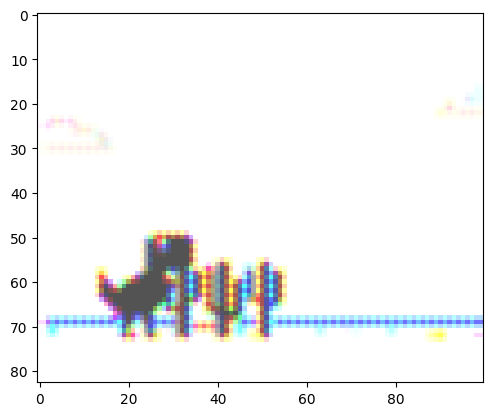

In [7]:
plt.imshow(cv2.cvtColor(obs[0], cv2.COLOR_BAYER_BG2BGR))

In [8]:
done, done_cap = env.get_done()

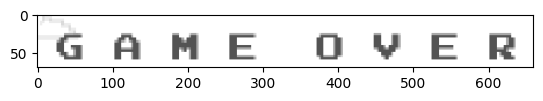

In [9]:
plt.imshow(done_cap)

In [10]:
pytesseract.image_to_string(done_cap)[:4]

'GAME'

In [11]:
done

True

In [ ]:
# play 5  games
for episode in range(5):
    # resets the game and returns a new observation
    obs = env.reset()
    done = False
    total_reward = 0
    
    while not done:
        obs, reward, done, _, info = env.step(env.action_space.sample())   # selects some actions and performs
        total_reward += reward
        print('Total Reward for episode {} is {}'.format(episode, total_reward))

# Training

## Callback

In [11]:
# file path management
import os
# import base callback fro saving models
from stable_baselines3.common.callbacks import BaseCallback
# check environment
from stable_baselines3.common import env_checker

In [12]:
# check environment is OK
env_checker.check_env(env)

In [13]:
# save model into a folder train
class TrainAndLoggingCallback(BaseCallback):

    #check_freq: how often to save the model the save path, verbose: the level to information callback prints to the console or log file
    def __init__(self, check_freq, save_path, verbose = 1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path
    
    # creates directory if it doesn't exist
    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok = True)

    # called periodically during training and determines when to save the model
    # checks if # calls are a multiple of check_freq
    # creates files with unique names and saves model
    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [14]:
CHECKPOINT_DIR = r'.\train'
LOG_DIR = r'.\logs'

In [15]:
# every 1000 tries we save our model
callback = TrainAndLoggingCallback(check_freq=1000, save_path = CHECKPOINT_DIR)

# Model 

In [16]:
from stable_baselines3 import DQN

In [17]:
# passing through an observation from our game / verbose - logging out results
# policy network architecture uses CNN for extracting features from the observation
# size of replay memory used by DQN / where agent stores experiences (state, action, reward, next state)
# model randomly samples replay to chose the next action to explore the environment
model  = DQN('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, buffer_size=120000, learning_starts=1000)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


c:\Users\anush\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.99GB > 1.42GB
  warnings.warn(


In [19]:
# start training
model.learn(total_timesteps=100000, callback=callback)

Logging to .\logs\DQN_4
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 13.2     |
|    ep_rew_mean      | 13.2     |
|    exploration_rate | 0.995    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 1        |
|    time_elapsed     | 28       |
|    total_timesteps  | 53       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 14.9     |
|    ep_rew_mean      | 14.9     |
|    exploration_rate | 0.989    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 1        |
|    time_elapsed     | 60       |
|    total_timesteps  | 119      |
----------------------------------


KeyboardInterrupt: 

# Testing Model

In [18]:
model.load(r'.\train\best_model_56000')

c:\Users\anush\AppData\Local\Programs\Python\Python310\lib\site-packages\stable_baselines3\common\buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 1.99GB > 1.37GB
  warnings.warn(


In [19]:
for episode in range(10): 
    obs = env.reset()
    done = False
    total_reward = 0
    obs = obs[0]
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, done, __, info = env.step(int(action)) 
        #time.sleep(0.01)
        total_reward += reward
    print('Total Reward for episode {} is {}'.format(episode, total_reward))
    time.sleep(1)

Total Reward for episode 0 is 7
Total Reward for episode 1 is 7
Total Reward for episode 2 is 7
Total Reward for episode 3 is 7
Total Reward for episode 4 is 7
Total Reward for episode 5 is 7
Total Reward for episode 6 is 7
Total Reward for episode 7 is 7


KeyboardInterrupt: 